# Modeling: Predicting Food Affordability
## RQ1: Which socioeconomic and geographic factors most strongly predict food affordability in California?

### Approach

To identify which socioeconomic and geographic factors most strongly predict food affordability in California, we focus on a small set of interpretable predictors:

* **Socioeconomic:** `median_income`
* **Geographic:** `region_name`
* **Demographic:** `race_eth_name`

**Why filter to `geotype == "PL"`?**
We restrict the analysis to place-level observations to keep the unit of analysis consistent (cities/towns/CDPs) and avoid mixing geographic levels that may have different variance structures.

**Modeling choice:**
We compare a baseline (mean-only) model to Ridge regression models using 1-, 2-, and 3-feature subsets. Ridge is a linear model that remains interpretable while stabilizing estimates when one-hot encoding categorical predictors.

**Important note on leakage / interpretability:**
We intentionally did not use`cost_yr` as a predictor here because `affordability_ratio` is conceptually tied to cost and income. Including variables that directly define the outcome can inflate predictive performance without answering “which contextual factors matter most.”

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from utils.model_utils import rmse, make_ridge_model, eval_model_rq1

RANDOM_STATE = 159
np.random.seed(RANDOM_STATE)

DATA_PATH = Path("./data/food_affordability.csv")
OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

In [2]:
df = pd.read_csv(DATA_PATH)

drop_cols = [
    "version", "ind_definition", "ind_id", "reportyear",
    "LL95_affordability_ratio", "UL95_affordability_ratio",
    "se_food_afford", "rse_food_afford",
    "county_name", "county_fips", "region_code",
    "ave_fam_size"
]
df = df.drop(columns=drop_cols, errors="ignore")

df.shape

(14365, 11)

In [3]:
TARGET = "affordability_ratio"
FULL_FEATURES = ["region_name", "race_eth_name", "median_income"]

# Filter to Place-level only
df_pl = df[df["geotype"] == "PL"].copy()

# Keep only rows where target and all full features exist
df_pl = df_pl.dropna(subset=[TARGET] + FULL_FEATURES).copy()

print("Rows after PL filter + dropna:", df_pl.shape[0])
df_pl[FULL_FEATURES + [TARGET]].head()

Rows after PL filter + dropna: 3003


,region_name,race_eth_name,median_income,affordability_ratio
539,Bay Area,Total,102750.0,0.057327
554,Southern California,White,12500.0,0.647035
557,Southern California,Total,12500.0,0.647035
560,Southern California,AfricanAm,17310.0,0.543686
561,Southern California,Latino,14933.0,0.630229


In [4]:
# one consistent split for fair comparison across models
X = df_pl[FULL_FEATURES].copy()
y = df_pl[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((2402, 3), (601, 3))

In [5]:
import itertools

features = FULL_FEATURES  # ["region_name", "race_eth_name", "median_income"]
results = []

# Baseline model
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
results.append({
    "model": "Dummy(mean)",
    "features": "",
    "RMSE": rmse(y_test, pred_dummy),
    "MAE": mean_absolute_error(y_test, pred_dummy),
    "R2": r2_score(y_test, pred_dummy),
})

# Models using 1 feature, 2 features, and all 3 features
for k in [1, 2, 3]:
    for subset in itertools.combinations(features, k):
        subset = list(subset)
        name = f"Ridge(log1p y) | {', '.join(subset)}"
        model = make_ridge_model(subset, X_train)

        out = eval_model_rq1(
            name,
            model,
            X_train[subset], X_test[subset],
            y_train, y_test
        )
        out["features"] = ", ".join(subset)
        results.append(out)

metrics_rq1 = pd.DataFrame(results).sort_values("RMSE")
metrics_rq1

,model,features,RMSE,MAE,R2
5,"Ridge(log1p y) | region_name, median_income","region_name, median_income",0.326686,0.144770,0.270545
3,Ridge(log1p y) | median_income,median_income,0.327603,0.149809,0.266445
7,"Ridge(log1p y) | region_name, race_eth_name, m...","region_name, race_eth_name, median_income",0.328525,0.145994,0.262311
6,"Ridge(log1p y) | race_eth_name, median_income","race_eth_name, median_income",0.329761,0.150958,0.256749
1,Ridge(log1p y) | region_name,region_name,0.375812,0.184413,0.034665
4,"Ridge(log1p y) | region_name, race_eth_name","region_name, race_eth_name",0.379931,0.183159,0.013385
0,Dummy(mean),,0.383904,0.219424,-0.007358
2,Ridge(log1p y) | race_eth_name,race_eth_name,0.388153,0.197312,-0.029778


In [6]:
metrics_rq1.to_csv(OUT_DIR / "rq1_pl_subset_models_metrics.csv", index=False)

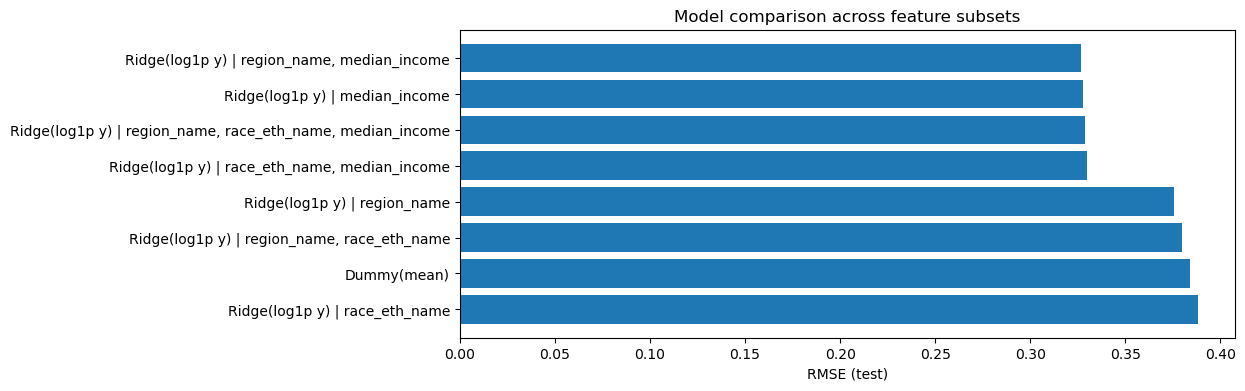

In [7]:
plt.figure(figsize=(10, 4))
plt.barh(metrics_rq1["model"][::-1], metrics_rq1["RMSE"][::-1])
plt.xlabel("RMSE (test)")
plt.title("Model comparison across feature subsets")
plt.savefig(FIG_DIR / "rq1_pl_subset_models_rmse.png", dpi=150, bbox_inches="tight")
plt.show()

Across the tested feature subsets, models that include **median income** perform best. The top-performing specification uses **`region_name + median_income`**, achieving **RMSE ≈ 0.3267** and **R² ≈ 0.2705** on the test set. Using `median_income` alone is nearly as good (**RMSE ≈ 0.3276**, **R² ≈ 0.2664**), suggesting that income is the dominant predictor in this setup.

Adding `race_eth_name` does **not** improve performance here (the 3-feature model has slightly worse RMSE/R² than the best 2-feature model). Meanwhile, `region_name` alone performs much worse (**R² near 0.03**), indicating that regional labels by themselves explain little unless income is included.

Overall, these results indicate that **median income** is the strongest predictor of food affordability, with **region** contributing a small additional gain beyond income in this place-level sample.